In [1]:
! pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [2]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [10]:
# import the necessary packages
from loader_util.projects.siamese import build_siamese_model
from loader_util.projects.siamese import config
from loader_util.projects.siamese import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [11]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = utils.make_pairs(trainX, trainY)
(pairTest, labelTest) = utils.make_pairs(testX, testY)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...
[INFO] looping over: 60000 times......
[INFO] looping over: 10000 times......


In [12]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.img_shape)
imgB = Input(shape=config.img_shape)

featureExtractor = build_siamese_model(config.img_shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [13]:
featureExtractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                       

In [14]:
# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])

# sigmoid activation function values closer to “1”
# imply more similar while values closer to “0”
# indicate “less similar.”
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [15]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 48)           19888       ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_2[0][0]',          

In [16]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=config.batch_size,
    epochs=config.num_epochs)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 15s 7ms/step - loss: 0.6214 - accuracy: 0.6444 - val_loss: 0.5520 - val_accuracy: 0.7394
Epoch 2/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5440 - accuracy: 0.7315 - val_loss: 0.4811 - val_accuracy: 0.7865
Epoch 3/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4992 - accuracy: 0.7610 - val_loss: 0.4375 - val_accuracy: 0.8085
Epoch 4/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4723 - accuracy: 0.7763 - val_loss: 0.4164 - val_accuracy: 0.8158
Epoch 5/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4518 - accuracy: 0.7887 - val_loss: 0.3910 - val_accuracy: 0.8275
Epoch 6/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4337 - accuracy: 0.8006 - val_loss: 0.3778 - val_accuracy: 0.8332
Epoch 7/100
1875/1875 [==============================] - 13s 7ms/step - l

[INFO] saving siamese model...


[INFO] plotting training history...


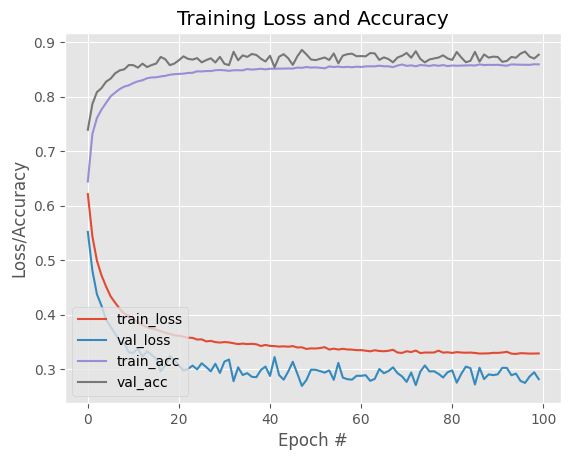

In [18]:
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.model_path)

# plot the training history
print("[INFO] plotting training history...")
utils.plot_training(history, config.plot_path)

In [17]:
config.model_path

'output/siamese_model'

In [20]:
!mv /content/output/* '/content/drive/MyDrive/Colab Notebooks/pyimagesearch/projects/siamese_networks_101/output/'